# Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay



In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
stopwords = set(stopwords.words('english'))

# Classes and Functions

In [5]:
hyperlink_regex = re.compile(r'&lt;A.*?&gt;.*?&lt;/A&gt;')
font_regex = re.compile(r'&lt;font.*?/font&gt;')
img_regex = re.compile(r'&lt;img.*?&gt;')
nobr_regex = re.compile(r'&lt;nobr&gt;.*?&lt;/nobr&gt;')

In [6]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

In [7]:
def read_dataset(filename, rmst=False):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)

        # remove header
        data = data[1:]

        # remove the first column
        data = [row[1:] for row in data]

    data = preprocess_data(data, rmst)

    return data

def preprocess_data(data, rmst=False):
    for i, row in enumerate(data):
        text = row[0]

        # Change text to lowercase
        text = text.lower()

        # Replace occurences of '#36;', "\$" or '#151;' or '#160;' with a space
        text = text.replace("#36;", " ")
        text = text.replace("\$ ", " ")
        text = text.replace("#151;", " ")
        text = text.replace("#160;", " ")
        text = text.replace("\\"," ")

        # Replace '#39;' or '#8217;' with an apostrophe
        text = text.replace("#39;", "")
        text = text.replace("#8217;", "")

        # Replace '#147;' or '#148;' with a double quote
        text = text.replace("#147;", '')
        text = text.replace("#148;", '')
        text = text.replace("quot;", '')

        # Remove occurences of some tags like bold, strong, etc.
        text = text.replace('&lt;br&gt;', ' ')
        text = text.replace('&lt;br/&gt;', ' ')
        text = text.replace('&lt;b&gt;...&lt;/b&gt;', ' ')
        text = text.replace('&lt;strong&gt;', ' ')
        text = text.replace('&lt;/strong&gt;', ' ')
        text = text.replace('&lt;cite&gt;is&lt;/cite&gt;', ' ')
        text = text.replace('&lt;p&gt;', ' ')
        text = text.replace('&lt;/p&gt;', ' ')
        text = text.replace('\&lt;p&gt;', ' ')
        text = text.replace('\&lt;hpq.n&gt;', ' ')
        text = text.replace('&lt;i&gt;', ' ')
        text = text.replace('&lt;/i&gt;', ' ')

        # Match and remove the regexes defined above
        text = hyperlink_regex.sub('', text)
        text = font_regex.sub('', text)
        text = img_regex.sub('', text)
        text = nobr_regex.sub('', text)

        # Remove \ in the text
        # First replace any possible escape characters like \', \n, \r, \t, \b, \f, \" with appropriate characters
        text = text.replace("\'", "")
        text = text.replace("\"", "")
        text = text.replace("\n", " n")
        text = text.replace("\r", " r")
        text = text.replace("\t", " t")
        text = text.replace("\b", " b")
        text = text.replace("\f", " f")

        # Remove any remaining \ in the text
        text = text.replace("\ ".replace(" ", ""), " ")

        text = ''.join([c if c.isalnum() or c.isspace() else ' ' for c in text])



        if rmst:
            text = remove_stopwords(text)

        row[0] = text

        # Converting the label to one-hot encoding
        label = np.zeros(4)
        label[int(row[1])] = 1
        row[1] = label

        data[i] = row

    return data

In [8]:
def create_vocab(dataset):
    sentences = [row[0] for row in dataset]

    tokens = [word_tokenize(sentence) for sentence in sentences]

    vocab = {}

    for token_list in tokens:
        for token in token_list:
            if token in vocab:
                vocab[token] += 1
            else:
                vocab[token] = 1

    vocab = [k for k, v in vocab.items()]

    tokenized_sentences = []

    for token_list in tokens:
        tokenized_sentences.append([token for token in token_list if token in vocab])

    return vocab, tokenized_sentences

In [9]:
def average_embeddings(sentence, embeddings, vector_size):
    avg = np.zeros(vector_size)
    count = 0

    for word in sentence:
        if word in embeddings:
            avg += embeddings[word]
            count += 1

    if count > 0:
        avg /= count
    else:
        avg = np.zeros(vector_size)

    return np.array(avg, dtype=np.float32)

In [10]:
# Neural Network class
class classifier_nn(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(classifier_nn, self).__init__()
        self.layers = nn.ModuleList()

        prev_layer_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_layer_size, hidden_size))
            self.layers.append(nn.ReLU())
            prev_layer_size = hidden_size

        self.output_layer = nn.Linear(prev_layer_size, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

def train_nn(model, train_loader, epochs, lr):
    model.train()

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch%10 == 0:
            print(f'Epoch {epoch}: Loss: {epoch_loss}')

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def get_perf(preds, labels):
    accuracy = np.mean(np.array(preds) == np.array(labels))

    f1 = f1_score(labels, preds, average='weighted')

    return accuracy, f1

def plot_conf_matrix(preds, labels):
    conf_matrix = confusion_matrix(labels, preds)
    ConfusionMatrixDisplay(conf_matrix).plot()

def save_predictions(preds, og_filename, filename):
    with open(og_filename, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
        data = data[1:]
    print("index,text,label,preds", file=open(filename, "w"))

    # write the lines such that the text string having a , does not mess up the csv file
    for i, row in enumerate(data):
        print(f"{i},\"{row[0]}\",{row[1]},{preds[i]}", file=open(filename, "a"))

In [11]:
# Data class
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [12]:
# Get vocabulary, word to idx and idx to word mappings from dataset
def get_vocab_mappings(dataset):
    vocab, tokenized_sentences = create_vocab(dataset)

    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocab, word_to_idx, idx_to_word

def tokenize(sentence, word_to_idx):
    return [word_to_idx[word] for word in sentence.split() if word in word_to_idx]

In [13]:
class Classifier_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, bidirectional=True):
        super(Classifier_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*2 if bidirectional else hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.fc(x)
        return x

class Classifier_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, bidirectional=True):
        super(Classifier_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.fc(x)
        return x

# Main

## Data files

In [14]:
train_file = './train.csv'
test_file = './test.csv'

## Task 1

### Data Preparation

In [15]:
train_data_task_1 = read_dataset(train_file, rmst=True)
test_data_task_1 = read_dataset(test_file, rmst=True)

# Now we set a 10% of the training data aside for validation
train_data_task_1, val_data_task_1 = train_test_split(train_data_task_1, test_size=0.1)

In [16]:
vocabulary_1, tokenized_sentences = create_vocab(train_data_task_1)

### Word2Vec

In [17]:
vec_size = 100
output_dim = 4
epoch_sizes = [10, 20, 40]

In [18]:
# Create the word2vec model using the train_data as the corpus
word2vec_model = Word2Vec(tokenized_sentences, vector_size=vec_size, window=5, min_count=1, workers=4)
word2vec_model.save('word2vec_model')

In [19]:
# Get embeddings for the vocabulary
embeddings = {}

for word in vocabulary_1:
    embeddings[word] = word2vec_model.wv[word]

In [20]:
# Split train data into X, y
X_train = [row[0] for row in train_data_task_1]
y_train = [row[1] for row in train_data_task_1]

X_train = [average_embeddings(word_tokenize(sentence), embeddings, vec_size) for sentence in X_train]

In [21]:
# Split validation data into X, y
X_val = [row[0] for row in val_data_task_1]
y_val = [row[1] for row in val_data_task_1]

X_val = [average_embeddings(word_tokenize(sentence), embeddings, vec_size) for sentence in X_val]

In [22]:
# Split test data into X, y
X_test = [row[0] for row in test_data_task_1]
y_test = [row[1] for row in test_data_task_1]

X_test = [average_embeddings(word_tokenize(sentence), embeddings, vec_size) for sentence in X_test]

### Neural Network

In [23]:
# load train_data into DataLoader
train_data = list(zip(X_train, y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# load val_data into DataLoader
val_data = list(zip(X_val, y_val))
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# load test_data into DataLoader
test_data = list(zip(X_test, y_test))
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Model 1:
* 1 hidden layer - 64 size

In [24]:
# Create the neural network
input_size = vec_size
hidden_sizes = [64]

model_1 = classifier_nn(input_size, hidden_sizes, output_dim).to(device)

train_nn(model_1, train_loader, 100, 0.01)

Epoch 0: Loss: 32.990274069976294
Epoch 10: Loss: 30.17938289239828
Epoch 20: Loss: 26.93724844687108
Epoch 30: Loss: 25.40361736910404
Epoch 40: Loss: 24.60121216444786
Epoch 50: Loss: 24.088001434234357
Epoch 60: Loss: 23.69859998563383
Epoch 70: Loss: 23.369290253367787
Epoch 80: Loss: 23.07226705374587
Epoch 90: Loss: 22.816620610289778


In [25]:
# Get accuracy on validation set
preds_1, labels_1 = get_predictions(model_1, val_loader)

accuracy_1, f1_1 = get_perf(preds_1, labels_1)

print(f'Accuracy: {accuracy_1}, F1: {f1_1}')

Accuracy: 0.56, F1: 0.5606362173350911


Model 2:
* 1 hidden layer - 128 size

In [26]:
# Create Neural network 2
input_size = vec_size
hidden_sizes = [128]

model_2 = classifier_nn(input_size, hidden_sizes, output_dim).to(device)

train_nn(model_2, train_loader, 100, 0.01)

Epoch 0: Loss: 32.91896582458139
Epoch 10: Loss: 29.426664521459315
Epoch 20: Loss: 26.041932257914823
Epoch 30: Loss: 24.84682541295409
Epoch 40: Loss: 24.37111986440522
Epoch 50: Loss: 23.982307227767613
Epoch 60: Loss: 23.64085085021787
Epoch 70: Loss: 23.31625262151782
Epoch 80: Loss: 23.049214197419793
Epoch 90: Loss: 22.804877071417458


In [27]:
# Get accuracy on validation set
preds_2, labels_2 = get_predictions(model_2, val_loader)

accuracy_2, f1_2 = get_perf(preds_2, labels_2)

print(f'Accuracy: {accuracy_2}, F1: {f1_2}')

Accuracy: 0.57, F1: 0.5710642602758024


Model 3:

* 2 hidden layers - sizes 64, 32

In [28]:
# Create Neural network 3
input_size = vec_size
hidden_sizes = [64, 32]

model_3 = classifier_nn(input_size, hidden_sizes, output_dim).to(device)

train_nn(model_3, train_loader, 100, 0.01)

Epoch 0: Loss: 33.03384268129594
Epoch 10: Loss: 30.839214341831394
Epoch 20: Loss: 27.440460394891943
Epoch 30: Loss: 26.339284365314356
Epoch 40: Loss: 25.355028167610385
Epoch 50: Loss: 24.568932287459553
Epoch 60: Loss: 24.386048887853185
Epoch 70: Loss: 23.741747609037436
Epoch 80: Loss: 23.532175758516924
Epoch 90: Loss: 23.029090741665797


In [29]:
# Get accuracy on validation set
preds_3, labels_3 = get_predictions(model_3, val_loader)

accuracy_3, f1_3 = get_perf(preds_3, labels_3)

print(f'Accuracy: {accuracy_3}, F1: {f1_3}')

Accuracy: 0.545, F1: 0.5400892153480522


In [59]:
best_model = model_2

In [60]:
# Get predictions, labels
preds, labels = get_predictions(best_model, test_loader)

In [61]:
# Get accuracy, f1
accuracy, f1 = get_perf(preds, labels)

print(f'Accuracy on test set: {accuracy}')
print(f'F1 score on test set: {f1}')

Accuracy on test set: 0.576
F1 score on test set: 0.5811455570757255


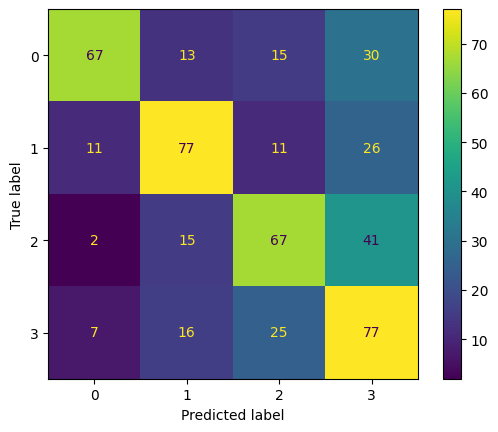

In [62]:
# Plot confusion matrix
plot_conf_matrix(preds, labels)

In [63]:
# Save the predictions to a csv file named "w2v_test.csv"
save_predictions(preds, "test.csv","w2v_test.csv")

### Recurrent Neural Networks

In [35]:
max_seq = 50
batch_size = 32

In [36]:
# load training dataset, test dataset
train_data_rnn = read_dataset(train_file, rmst=True)
test_data_rnn = read_dataset(test_file, rmst=True)

train_data_rnn, val_data_rnn = train_test_split(train_data_rnn, test_size=0.1)

In [37]:
# Get vocabulary, word to idx and idx to word mappings
vocab_rnn, word_to_idx, idx_to_word = get_vocab_mappings(train_data_rnn)

In [38]:
sentences_rnn = [row[0] for row in train_data_rnn]

tokenized_sentences = [tokenize(sentence, word_to_idx) for sentence in sentences_rnn]

# truncate the sentences to max_seq length
truncated_sentences = [sentence[:max_seq] for sentence in tokenized_sentences]
padded_sentences = pad_sequence([torch.tensor(seq) for seq in truncated_sentences], batch_first=True)

labels_tensor = torch.tensor([row[1] for row in train_data_rnn], dtype=torch.float32)

<ipython-input-38-ca2f2be2189f>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  labels_tensor = torch.tensor([row[1] for row in train_data_rnn], dtype=torch.float32)


In [39]:
train_dataset = list(zip(padded_sentences, labels_tensor))
train_loader_rnn = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [40]:
val_sentences = [row[0] for row in val_data_rnn]

val_tokenized_sentences = [tokenize(sentence, word_to_idx) for sentence in val_sentences]

val_truncated_sentences = [sentence[:max_seq] for sentence in val_tokenized_sentences]
val_padded_sentences = pad_sequence([torch.tensor(seq) for seq in val_truncated_sentences], batch_first=True)

val_labels_tensor = torch.tensor([row[1] for row in val_data_rnn], dtype=torch.float32)

In [41]:
val_dataset = list(zip(val_padded_sentences, val_labels_tensor))
val_loader_rnn = DataLoader(val_dataset, batch_size=32, shuffle=False)

RNN Models

In [42]:
# Model with hidden layer size 32
vocab_size = len(vocab_rnn)
embedding_dim = 100
hidden_size = 32
num_layers = 1
num_classes = 4

model_rnn_1 = Classifier_RNN(vocab_size, embedding_dim, hidden_size, num_layers, num_classes).to(device)

train_nn(model_rnn_1, train_loader_rnn, 100, 0.01)

Epoch 0: Loss: 30.0339734852314
Epoch 10: Loss: 0.20361041487194598
Epoch 20: Loss: 0.6353277321904898
Epoch 30: Loss: 0.03712053316121455
Epoch 40: Loss: 0.012758477831084747
Epoch 50: Loss: 0.008962708750914317
Epoch 60: Loss: 0.005340475236152997
Epoch 70: Loss: 0.0035173444885003846
Epoch 80: Loss: 0.0032464945506944787
Epoch 90: Loss: 0.00289845308088843


In [43]:
# Get accuracy on validation set
preds_rnn_1, labels_rnn_1 = get_predictions(model_rnn_1, val_loader_rnn)

accuracy_rnn_1, f1_rnn_1 = get_perf(preds_rnn_1, labels_rnn_1)

print(f'Accuracy: {accuracy_rnn_1}, F1: {f1_rnn_1}')

Accuracy: 0.77, F1: 0.7741529870646408


In [44]:
# Model with hidden layer size 64
hidden_size = 64

model_rnn_2 = Classifier_RNN(vocab_size, embedding_dim, hidden_size, num_layers, num_classes).to(device)

train_nn(model_rnn_2, train_loader_rnn, 100, 0.01)

Epoch 0: Loss: 28.874938040971756
Epoch 10: Loss: 0.045075286470819265
Epoch 20: Loss: 0.01069581263436703
Epoch 30: Loss: 0.05717232736060396
Epoch 40: Loss: 0.01740483914181823
Epoch 50: Loss: 0.006609268642932875
Epoch 60: Loss: 0.009439125315111596
Epoch 70: Loss: 0.0023545574649688206
Epoch 80: Loss: 0.0016112415382849576
Epoch 90: Loss: 0.0015549083973382949


In [45]:
# Get accuracy on validation set
preds_rnn_2, labels_rnn_2 = get_predictions(model_rnn_2, val_loader_rnn)

accuracy_rnn_2, f1_rnn_2 = get_perf(preds_rnn_2, labels_rnn_2)

print(f'Accuracy: {accuracy_rnn_2}, F1: {f1_rnn_2}')

Accuracy: 0.725, F1: 0.7287332052616914


In [46]:
best_model_rnn = model_rnn_1

In [47]:
# Get and load test dataset
test_sentences = [row[0] for row in test_data_rnn]

test_tokenized_sentences = [tokenize(sentence, word_to_idx) for sentence in test_sentences]

test_truncated_sentences = [sentence[:max_seq] for sentence in test_tokenized_sentences]

test_padded_sentences = pad_sequence([torch.tensor(seq) for seq in test_truncated_sentences], batch_first=True)

test_labels_tensor = torch.tensor([row[1] for row in test_data_rnn], dtype=torch.float32)

test_dataset = list(zip(test_padded_sentences, test_labels_tensor))

test_loader_rnn = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# Get best_model accuracy on test set
preds_rnn, labels_rnn = get_predictions(best_model_rnn, test_loader_rnn)

accuracy_rnn, f1_rnn = get_perf(preds_rnn, labels_rnn)

print(f'Accuracy on test set: {accuracy_rnn}')
print(f'F1 score on test set: {f1_rnn}')

Accuracy on test set: 0.796
F1 score on test set: 0.7971135361346713


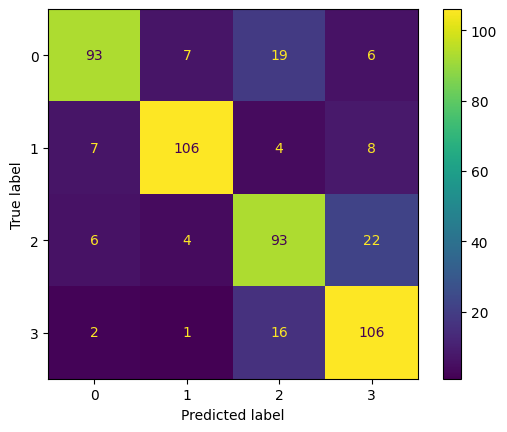

In [49]:
# Plot confusion matrix
plot_conf_matrix(preds_rnn, labels_rnn)

In [50]:
# Save the predictions to a csv file named "rnn_test.csv"
save_predictions(preds_rnn, "test.csv","rnn_test.csv")

LSTM models

In [51]:
# Model 1 with hidden layer size 32
vocab_size = len(vocab_rnn)
embedding_dim = 100
hidden_size = 32
num_layers = 1
num_classes = 4

model_lstm_1 = Classifier_LSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes).to(device)

train_nn(model_lstm_1, train_loader_rnn, 100, 0.01)

Epoch 0: Loss: 29.093553096055984
Epoch 10: Loss: 0.03250380925601348
Epoch 20: Loss: 0.008974658434453886
Epoch 30: Loss: 0.018626570876222104
Epoch 40: Loss: 0.004734185062261531
Epoch 50: Loss: 0.0025125767788267694
Epoch 60: Loss: 0.0012874177473349846
Epoch 70: Loss: 0.0008972523874035687
Epoch 80: Loss: 0.0006034874008946645
Epoch 90: Loss: 0.0004138978774790303


In [52]:
# Get validation set accuracy
preds_lstm_1, labels_lstm_1 = get_predictions(model_lstm_1, val_loader_rnn)

accuracy_lstm_1, f1_lstm_1 = get_perf(preds_lstm_1, labels_lstm_1)

print(f'Accuracy: {accuracy_lstm_1}, F1: {f1_lstm_1}')

Accuracy: 0.755, F1: 0.7545073421385661


In [53]:
# Model 2 with hidden layer size 64
hidden_size = 64

model_lstm_2 = Classifier_LSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes).to(device)

train_nn(model_lstm_2, train_loader_rnn, 100, 0.01)

Epoch 0: Loss: 27.26800000667572
Epoch 10: Loss: 0.03241558920126408
Epoch 20: Loss: 0.009212126889906358
Epoch 30: Loss: 0.006964959809920401
Epoch 40: Loss: 0.0018836665358321625
Epoch 50: Loss: 0.0006521880429772864
Epoch 60: Loss: 0.00038606115936090646
Epoch 70: Loss: 0.0002186126273500122
Epoch 80: Loss: 0.00014752493768810382
Epoch 90: Loss: 0.00010642094832746807


In [54]:
# Get validation set accuracy
preds_lstm_2, labels_lstm_2 = get_predictions(model_lstm_2, val_loader_rnn)

accuracy_lstm_2, f1_lstm_2 = get_perf(preds_lstm_2, labels_lstm_2)

print(f'Accuracy: {accuracy_lstm_2}, F1: {f1_lstm_2}')

Accuracy: 0.65, F1: 0.6479103453181123


In [55]:
best_model_lstm = model_lstm_1

In [64]:
# Get test set accuracy
preds_lstm, labels_lstm = get_predictions(best_model_lstm, test_loader_rnn)

accuracy_lstm, f1_lstm = get_perf(preds_lstm, labels_lstm)

print(f'Accuracy on test set: {accuracy_lstm}')
print(f'F1 score on test set: {f1_lstm}')


Accuracy on test set: 0.788
F1 score on test set: 0.7862526401119798


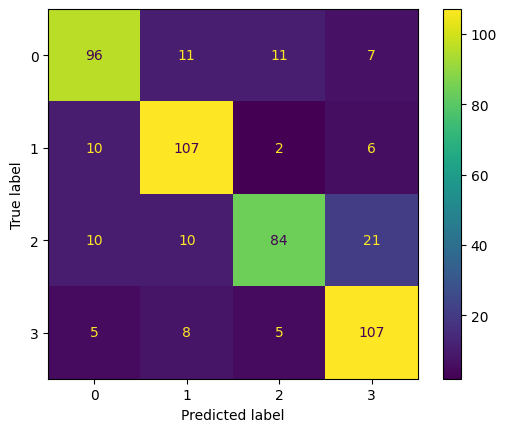

In [65]:
# Plot confusion matrix
plot_conf_matrix(preds_lstm, labels_lstm)


In [58]:
# Save the predictions to a csv file named "lstm_test.csv"
save_predictions(preds_lstm, "test.csv","lstm_test.csv")